In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score,make_scorer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

import joblib

weatherAus=pd.read_csv('weatherAUS.csv')
#Agrupamos las ciudades de los estados pedidos en la consigna
victoria = [
    "Melbourne", "Ballarat", "Sale", "Watsonia", "Dartmoor",
    "Portland", "MelbourneAirport", "Mildura"
]
nueva_gales_del_sur = [
    "Sydney", "Penrith", "Wollongong", "Newcastle",
    "CoffsHarbour", "WaggaWagga", "NorahHead", "BadgerysCreek",
    "Richmond", "Williamtown"
]

locations = victoria + nueva_gales_del_sur
weather_filtrado = weatherAus[weatherAus['Location'].isin(locations)]

ubicaciones_estado = {}
for ciudad in victoria:
    ubicaciones_estado[ciudad] = "Victoria"

for ciudad in nueva_gales_del_sur:
    ubicaciones_estado[ciudad] = "Nueva Gales del Sur"

#Agregamos una nueva columna llamada estado para diferenciar a que estado pertenece de los 2 que estamos analizando
weather_filtrado = weather_filtrado.copy()
weather_filtrado['Estado'] = weather_filtrado['Location'].map(ubicaciones_estado)
print(weatherAus.shape)
print(weather_filtrado.shape)
weather_filtrado.head()

(145460, 23)
(54798, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Estado
3040,2009-01-01,BadgerysCreek,13.3,34.2,0.0,NaN,NaN,W,61.0,NNE,...,NaN,1005.6,NaN,NaN,NaN,21.0,NaN,No,No,Nueva Gales del Sur
3041,2009-01-02,BadgerysCreek,14.7,26.1,0.0,NaN,NaN,SE,46.0,SE,...,54.0,1012.9,1013.5,NaN,NaN,20.7,22.2,No,No,Nueva Gales del Sur
3042,2009-01-03,BadgerysCreek,13.6,22.3,0.0,NaN,NaN,NNE,30.0,ESE,...,51.0,1021.9,1019.2,NaN,NaN,17.9,21.7,No,No,Nueva Gales del Sur
3043,2009-01-04,BadgerysCreek,17.7,31.2,0.0,NaN,NaN,NE,39.0,NNE,...,43.0,1018.7,1013.6,NaN,NaN,22.0,30.6,No,No,Nueva Gales del Sur
3044,2009-01-05,BadgerysCreek,15.5,38.8,0.0,NaN,NaN,SW,50.0,NNE,...,19.0,1013.2,1007.6,NaN,NaN,22.7,37.6,No,No,Nueva Gales del Sur


In [3]:
#Pasamos la fecha a columnas separadas de año, mes y dia para mejorar el modelo
#Además agregamos la columna estacion para tener otro parametro de diferencia
weather_filtrado['Date'] = pd.to_datetime(weather_filtrado['Date'])

def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    elif mes in [9, 10, 11]:
        return 'Primavera'

# Crear nuevas columnas
weather_filtrado['Year'] = weather_filtrado['Date'].dt.year
weather_filtrado['Month'] = weather_filtrado['Date'].dt.month
weather_filtrado['Day'] = weather_filtrado['Date'].dt.day
weather_filtrado['Estacion'] = weather_filtrado['Date'].dt.month.map(obtener_estacion)

# Eliminar la columna original
weather_filtrado = weather_filtrado.drop('Date', axis=1)

In [4]:
weather_filtrado.columns.tolist()

['Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow',
 'Estado',
 'Year',
 'Month',
 'Day',
 'Estacion']

In [5]:
filas_totales = weather_filtrado.shape[0]
print("Porcentajes de datos faltantes:")
porcentaje_por_columna = weather_filtrado.isna().sum() / filas_totales * 100
print(porcentaje_por_columna)

Porcentajes de datos faltantes:
Location          0.000000
MinTemp           1.939852
MaxTemp           1.669769
Rainfall          3.383335
Evaporation      44.072776
Sunshine         49.293770
WindGustDir       9.575167
WindGustSpeed     9.569692
WindDir9am        9.659112
WindDir3pm        4.118763
WindSpeed9am      1.620497
WindSpeed3pm      2.779299
Humidity9am       2.529289
Humidity3pm       3.624220
Pressure9am      13.327129
Pressure3pm      13.274207
Cloud9am         38.397387
Cloud3pm         40.917552
Temp9am           1.954451
Temp3pm           3.076755
RainToday         3.383335
RainTomorrow      3.379685
Estado            0.000000
Year              0.000000
Month             0.000000
Day               0.000000
Estacion          0.000000
dtype: float64


In [6]:
#Eliminamos columnas que tienen demasiados nulos y no aportan mucha informacion
columnas_eliminar_NANs = ["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"]
weather_filtrado.drop(columnas_eliminar_NANs, axis="columns", inplace=True)

In [7]:
#Imputamos los datos faltantes

numericas = weather_filtrado.select_dtypes(include=['int64', 'float64']).columns
imputador_numerico = SimpleImputer(strategy='median')
weather_filtrado[numericas] = imputador_numerico.fit_transform(weather_filtrado[numericas])

categoricas = weather_filtrado.select_dtypes(include=['object']).columns
imputador_categorico = SimpleImputer(strategy='most_frequent')
weather_filtrado[categoricas] = imputador_categorico.fit_transform(weather_filtrado[categoricas])

In [8]:
filas_totales = weather_filtrado.shape[0]
print("Porcentajes de datos faltantes:")
porcentaje_por_columna = weather_filtrado.isna().sum() / filas_totales * 100
print(porcentaje_por_columna)

Porcentajes de datos faltantes:
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Estado           0.0
Year             0.0
Month            0.0
Day              0.0
Estacion         0.0
dtype: float64


In [9]:
#Como los arboles no puede trabajar con variables categoricas, por lo que hacemos el dummies
weather_filtrado = pd.get_dummies(weather_filtrado, columns=["WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow", "Estado", "Estacion"], drop_first=True)
weather_filtrado = weather_filtrado.drop('Location', axis=1)
weather_filtrado.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes,Estado_Victoria,Estacion_Otoño,Estacion_Primavera,Estacion_Verano
3040,13.3,34.2,0.0,61.0,11.0,19.0,67.0,55.0,1005.6,1016.2,...,False,False,False,False,False,False,False,False,False,True
3041,14.7,26.1,0.0,46.0,7.0,24.0,59.0,54.0,1012.9,1013.5,...,False,False,False,False,False,False,False,False,False,True
3042,13.6,22.3,0.0,30.0,6.0,15.0,57.0,51.0,1021.9,1019.2,...,False,False,False,False,False,False,False,False,False,True
3043,17.7,31.2,0.0,39.0,9.0,15.0,62.0,43.0,1018.7,1013.6,...,False,False,False,False,False,False,False,False,False,True
3044,15.5,38.8,0.0,50.0,7.0,17.0,67.0,19.0,1013.2,1007.6,...,False,True,False,False,False,False,False,False,False,True


In [10]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=weather_filtrado.drop(['RainTomorrow_Yes'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = weather_filtrado['RainTomorrow_Yes'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.2,
                                                    random_state=12) #semilla

#Arbol de Decision

In [11]:
# Parámetros
params_grid = {
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': np.linspace(0, 0.05, 20),
    'max_depth': list(range(1, 15)),  # Más profundo
    'min_samples_split': [2, 5, 10, 20],  # Agregado
    'min_samples_leaf': [1, 5, 10, 20]    # Agregado
}

folds = 8
n = 50  # Más combinaciones

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier(class_weight='balanced')  # Clase balanceada

scorer_fn = make_scorer(f1_score, average='macro')  # Macro promedio

randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=42)

# Entrenar
randomcv.fit(x_train, y_train)

# Mejor score
print("Mejor F1 score:", randomcv.best_score_)
print("Mejores hiperparámetros:", randomcv.best_params_)

Mejor F1 score: 0.7044860366468602
Mejores hiperparámetros: {'min_samples_split': 2, 'min_samples_leaf': 20, 'max_depth': 12, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.002631578947368421)}


In [12]:
arbol=DecisionTreeClassifier(class_weight='balanced').set_params(**randomcv.best_params_)
joblib.dump(arbol, 'modelo_arbol_decision.joblib')

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.002631578947368421),
                       class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=20)

              precision    recall  f1-score   support

       False       0.88      0.88      0.88      8510
        True       0.57      0.57      0.57      2450

    accuracy                           0.81     10960
   macro avg       0.72      0.72      0.72     10960
weighted avg       0.81      0.81      0.81     10960



Text(50.722222222222214, 0.5, 'True')

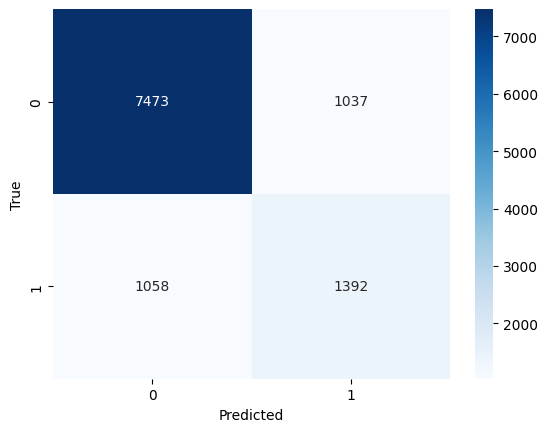

In [34]:
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [35]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

y_train_pred = arbol.predict(x_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nTrain: ")
print("Train Accuracy:", accuracy_train)
print("Train Recall:", recall_train)
print("Train Precision:", precision_train)
print("Train F1 Score:", f1_train)

Accuracy: 0.8088503649635036
Recall: 0.5681632653061225
Precision: 0.5730753396459448
f1 score: 0.570608731297397

Train: 
Train Accuracy: 0.8113052602764724
Train Recall: 0.5771955361475012
Train Precision: 0.603061948697151
Train F1 Score: 0.5898452994843316


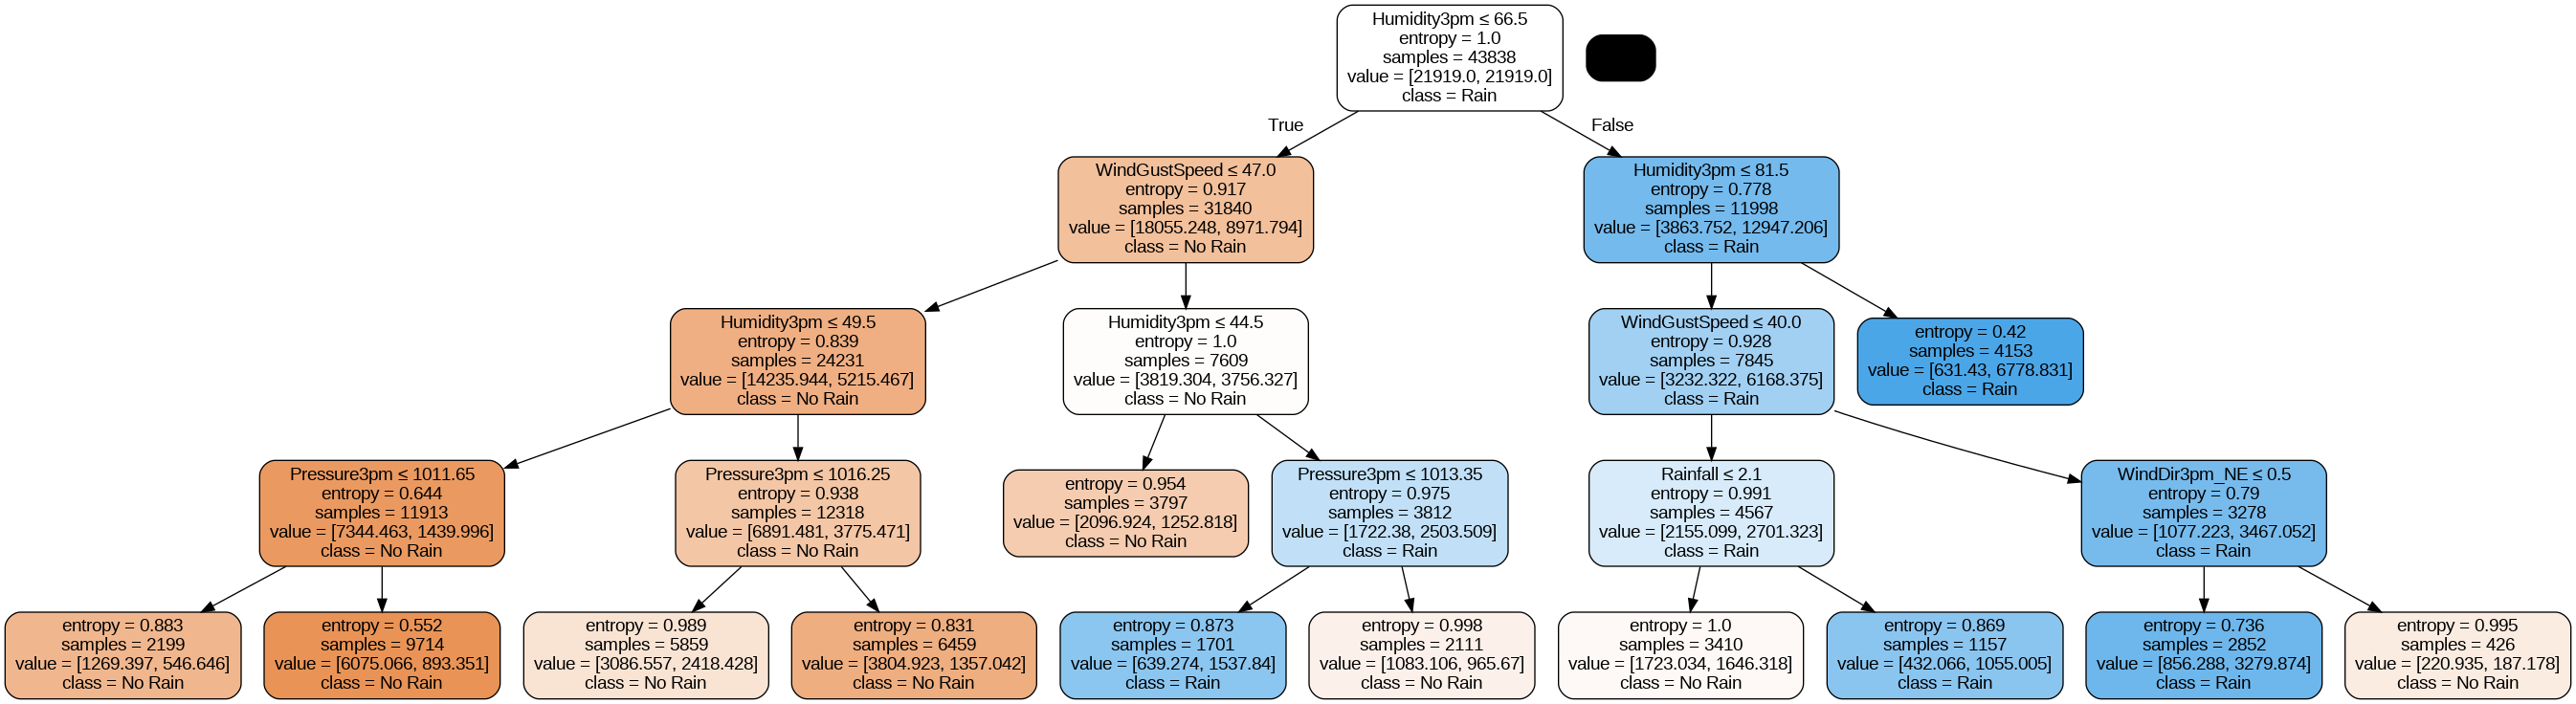

In [36]:
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=x_train.columns,
                class_names=['No Rain', 'Rain'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#Random Forest

In [13]:
rf_cv = RandomForestClassifier(
    oob_score=True,
    random_state=1,
    n_jobs=-1,
    class_weight='balanced'
)

param_dist = {
    "n_estimators": [10, 20, 50],
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10],
    "min_samples_leaf": [2, 5, 10],
    "min_samples_split": [4, 8, 12]
}

random_search = RandomizedSearchCV(
    estimator=rf_cv,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1),
    random_state=1,
    n_jobs=-1,
    verbose=1
)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1, oob_score=True,
                                                    random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [4, 8, 12],
                                        'n_estimators': [10, 20, 50]},
                   random_state=1, scoring='f1', verbose=1)

In [14]:
rf_cv_best=random_search.best_estimator_
joblib.dump(rf_cv_best, 'modelo_random_forest.joblib')

#Predicción
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

              precision    recall  f1-score   support

       False       0.91      0.84      0.87      8510
        True       0.56      0.70      0.62      2450

    accuracy                           0.81     10960
   macro avg       0.73      0.77      0.75     10960
weighted avg       0.83      0.81      0.82     10960



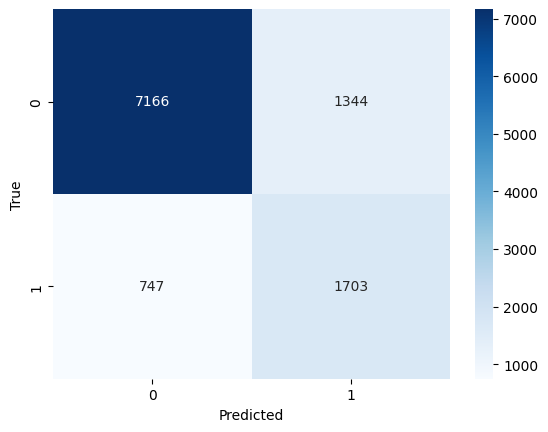

In [39]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

In [40]:
accuracy=accuracy_score(y_test,y_pred_rf_cv_best)
recall=recall_score(y_test,y_pred_rf_cv_best)
f1=f1_score(y_test,y_pred_rf_cv_best,)
precision=precision_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

y_train_pred_rf_cv_best = rf_cv_best.predict(x_train)

accuracy_train_rf_cv_best = accuracy_score(y_train, y_train_pred_rf_cv_best)
recall_train_rf_cv_best = recall_score(y_train, y_train_pred_rf_cv_best)
precision_train_rf_cv_best = precision_score(y_train, y_train_pred_rf_cv_best)
f1_train_rf_cv_best = f1_score(y_train, y_train_pred_rf_cv_best)

print("\nTrain: ")
print("Train Accuracy:", accuracy_train_rf_cv_best)
print("Train Recall:", recall_train_rf_cv_best)
print("Train Precision:", precision_train_rf_cv_best)
print("Train F1 Score:", f1_train_rf_cv_best)

Accuracy: 0.8092153284671533
Recall: 0.6951020408163265
Precision: 0.5589104036757466
f1 score: 0.6196106967436784

Train: 
Train Accuracy: 0.830991377343857
Train Recall: 0.7509946627850558
Train Precision: 0.6150850421236688
Train F1 Score: 0.6762791104120243


In [42]:
#Importancia de los atributos
importances = sorted(
    [(col, round(float(imp), 8)) for col, imp in zip(ds_trabajo_x.columns, rf_cv_best.feature_importances_)],
    key=lambda x: -x[1]
)

importances

[('Humidity3pm', 0.31346488),
 ('Pressure3pm', 0.07513342),
 ('Rainfall', 0.0656474),
 ('Temp3pm', 0.06072555),
 ('WindGustSpeed', 0.06029844),
 ('RainToday_Yes', 0.05841508),
 ('Pressure9am', 0.05564989),
 ('Humidity9am', 0.05441875),
 ('MinTemp', 0.04248237),
 ('MaxTemp', 0.04076384),
 ('Temp9am', 0.02642234),
 ('WindSpeed9am', 0.01624538),
 ('WindSpeed3pm', 0.0155721),
 ('Estado_Victoria', 0.01512567),
 ('Month', 0.01217568),
 ('Day', 0.01146496),
 ('Year', 0.00822629),
 ('Estacion_Verano', 0.0037571),
 ('WindDir3pm_NE', 0.00328416),
 ('WindGustDir_N', 0.00273811),
 ('WindGustDir_NE', 0.00266989),
 ('WindDir3pm_W', 0.0024044),
 ('WindDir3pm_N', 0.00232112),
 ('Estacion_Otoño', 0.00229499),
 ('WindDir9am_N', 0.00206637),
 ('Estacion_Primavera', 0.00189012),
 ('WindGustDir_W', 0.00178753),
 ('WindDir3pm_S', 0.00169126),
 ('WindDir3pm_NNW', 0.00160042),
 ('WindDir3pm_SSW', 0.00147916),
 ('WindDir9am_W', 0.00147732),
 ('WindDir3pm_SSE', 0.00146293),
 ('WindDir9am_WNW', 0.001457),
 ('Win

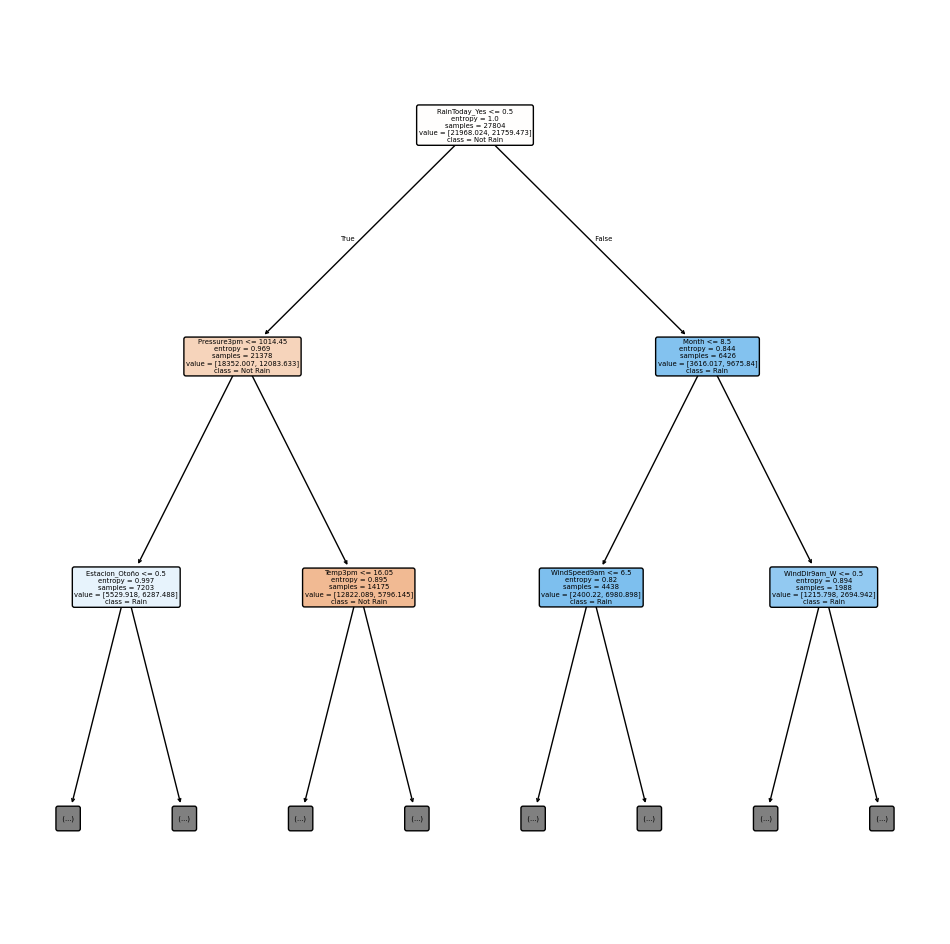

In [43]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(rf_cv_best.estimators_[35],
                         max_depth=2,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=['Not Rain','Rain'])

plt.show(tree_plot)

#Ada Boost

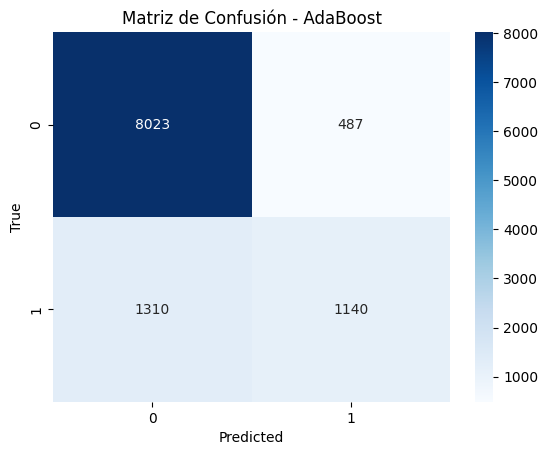

In [15]:
n_iter_search = 20

# Definir modelo base
dt = DecisionTreeClassifier()

# AdaBoost con árbol como estimador base
ab_model = AdaBoostClassifier(estimator=dt, random_state=0)

# Hiperparámetros
param_dist = {
    'n_estimators': [10, 20, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'estimator__max_depth': [1, 2, 3]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=ab_model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    random_state=1,
    n_jobs=-1,
    error_score='raise'
)

# Entrenamiento
random_search.fit(x_train, y_train)
ab_best = random_search.best_estimator_

# Predicciones
y_pred_ab = ab_best.predict(x_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_ab)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - AdaBoost')
plt.show()

In [16]:
joblib.dump(ab_best, 'modelo_ada_boost.joblib')

['modelo_ada_boost.joblib']

In [45]:
accuracy=accuracy_score(y_test,y_pred_ab)
recall=recall_score(y_test,y_pred_ab)
f1=f1_score(y_test,y_pred_ab,)
precision=precision_score(y_test,y_pred_ab)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

y_train_ab_best = ab_best.predict(x_train)

accuracy_train_ab_best = accuracy_score(y_train, y_train_ab_best)
recall_train_ab_best = recall_score(y_train, y_train_ab_best)
precision_train_ab_best = precision_score(y_train, y_train_ab_best)
f1_train_ab_best = f1_score(y_train, y_train_ab_best)

print("\nTrain: ")
print("Train Accuracy:", accuracy_train_ab_best)
print("Train Recall:", recall_train_ab_best)
print("Train Precision:", precision_train_ab_best)
print("Train F1 Score:", f1_train_ab_best)

Accuracy: 0.8360401459854014
Recall: 0.46530612244897956
Precision: 0.7006760909649662
f1 score: 0.5592347314201619

Train: 
Train Accuracy: 0.8355992517906838
Train Recall: 0.4739446870451237
Train Precision: 0.7322338830584708
Train F1 Score: 0.5754344624447717
